In [1]:
import os
import torch
from DataReader import load_data, train_vaild_split
from Model import Cifar

def run_experiment(batch_size, save_interval, weight_decay, learning_rate, modeldir, use_residual, use_bn, device, save_checkpoint_model = False):
    # Set up config
    class Config:
        def __init__(self):
            self.batch_size = batch_size
            self.save_interval = save_interval
            self.weight_decay = weight_decay
            self.lr = learning_rate
            self.modeldir = modeldir
            self.use_residual = use_residual
            self.use_bn = use_bn
            self.device = device
    
    config = Config()
    
    # Load and split data
    data_dir = "dataset/cifar-10-batches-py"
    x_train, y_train, x_test, y_test = load_data(data_dir)
    x_train_new, y_train_new, x_valid, y_valid = train_vaild_split(x_train, y_train)

    # Initialize and train the model
    model = Cifar(config).to(device)
    print(f"\n--- Training with learning rate {learning_rate}, Residual: {use_residual}, BatchNorm: {use_bn} ---")
    #model.train(x_train_new, y_train_new, 100)
    model.train_test_accuracy(x_train_new, y_train_new, x_test, y_test, 100, save_checkpoint_model)

    if save_checkpoint_model:
        # Validate and test
        print("\n--- Validation ---")
        model.test_or_validate(x_valid, y_valid, [80, 90, 100])
        print("\n--- Test ---")
        model.test_or_validate(x_test, y_test, [100])


--- Training with learning rate 0.003, Residual: True, BatchNorm: False ---
### Training... ###
Epoch 1 Loss 2.046582 Duration 10.386 seconds, LR: 0.003000.
Epoch 2 Loss 1.727656 Duration 9.886 seconds, LR: 0.003000.
Epoch 3 Loss 1.543348 Duration 9.919 seconds, LR: 0.003000.
Epoch 4 Loss 1.404295 Duration 9.994 seconds, LR: 0.003000.
Epoch 5 Loss 1.307581 Duration 9.681 seconds, LR: 0.003000.
Epoch 6 Loss 1.249792 Duration 9.952 seconds, LR: 0.003000.
Epoch 7 Loss 1.198046 Duration 10.147 seconds, LR: 0.003000.
Epoch 8 Loss 1.154891 Duration 10.090 seconds, LR: 0.003000.
Epoch 9 Loss 1.124265 Duration 9.716 seconds, LR: 0.003000.
Epoch 10 Loss 1.101432 Duration 10.164 seconds, LR: 0.003000.
Checkpoint has been created.
Epoch 10/100, Testing Loss: 1.3301
Epoch 11 Loss 1.022357 Duration 10.244 seconds, LR: 0.002000.
Epoch 12 Loss 0.983365 Duration 9.692 seconds, LR: 0.002000.
Epoch 13 Loss 0.958873 Duration 9.855 seconds, LR: 0.002000.
Epoch 14 Loss 0.945038 Duration 10.192 seconds, LR

100%|██████████| 10000/10000 [00:08<00:00, 1210.43it/s]



Final Testing Accuracy: 0.7919


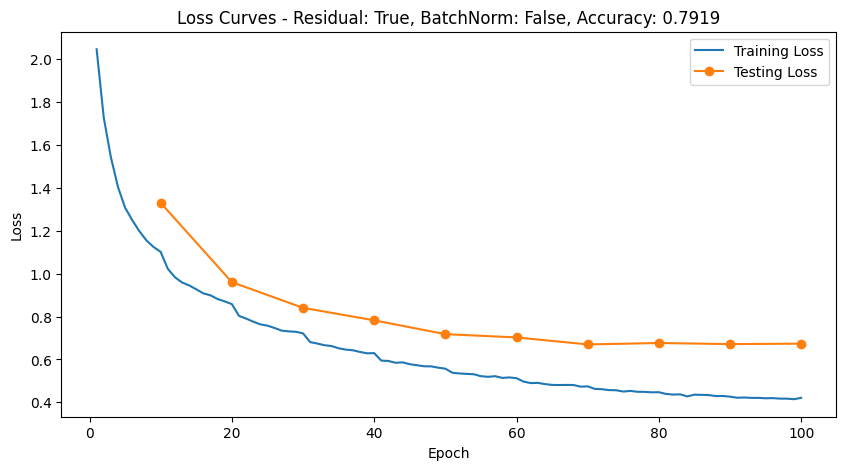

/home/grads/s/skpaul/Deep-ResNet-CIFAR-10/Model.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_name, map_location=self.config.device)



--- Validation ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_bn/0.003/model-80.ckpt


100%|██████████| 5000/5000 [00:04<00:00, 1181.76it/s]


Checkpoint 80 Test accuracy: 0.7904
Restored model parameters from models/resnet18_no_bn/0.003/model-90.ckpt


100%|██████████| 5000/5000 [00:04<00:00, 1208.27it/s]


Checkpoint 90 Test accuracy: 0.7962
Restored model parameters from models/resnet18_no_bn/0.003/model-100.ckpt


100%|██████████| 5000/5000 [00:04<00:00, 1228.79it/s]


Checkpoint 100 Test accuracy: 0.7974

--- Test ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_bn/0.003/model-100.ckpt


100%|██████████| 10000/10000 [00:08<00:00, 1226.14it/s]


Checkpoint 100 Test accuracy: 0.7919

--- Training with learning rate 0.003, Residual: False, BatchNorm: True ---
### Training... ###
Epoch 1 Loss 1.940177 Duration 9.903 seconds, LR: 0.003000.
Epoch 2 Loss 1.647618 Duration 9.816 seconds, LR: 0.003000.
Epoch 3 Loss 1.504525 Duration 10.256 seconds, LR: 0.003000.
Epoch 4 Loss 1.421006 Duration 10.416 seconds, LR: 0.003000.
Epoch 5 Loss 1.365220 Duration 10.240 seconds, LR: 0.003000.
Epoch 6 Loss 1.318857 Duration 10.266 seconds, LR: 0.003000.
Epoch 7 Loss 1.274761 Duration 9.951 seconds, LR: 0.003000.
Epoch 8 Loss 1.262382 Duration 9.994 seconds, LR: 0.003000.
Epoch 9 Loss 1.227901 Duration 10.184 seconds, LR: 0.003000.
Epoch 10 Loss 1.222431 Duration 10.331 seconds, LR: 0.003000.
Checkpoint has been created.
Epoch 10/100, Testing Loss: 1.3954
Epoch 11 Loss 1.143486 Duration 10.079 seconds, LR: 0.002000.
Epoch 12 Loss 1.114927 Duration 9.810 seconds, LR: 0.002000.
Epoch 13 Loss 1.119127 Duration 10.079 seconds, LR: 0.002000.
Epoch 14 L

100%|██████████| 10000/10000 [00:10<00:00, 933.30it/s]



Final Testing Accuracy: 0.7167


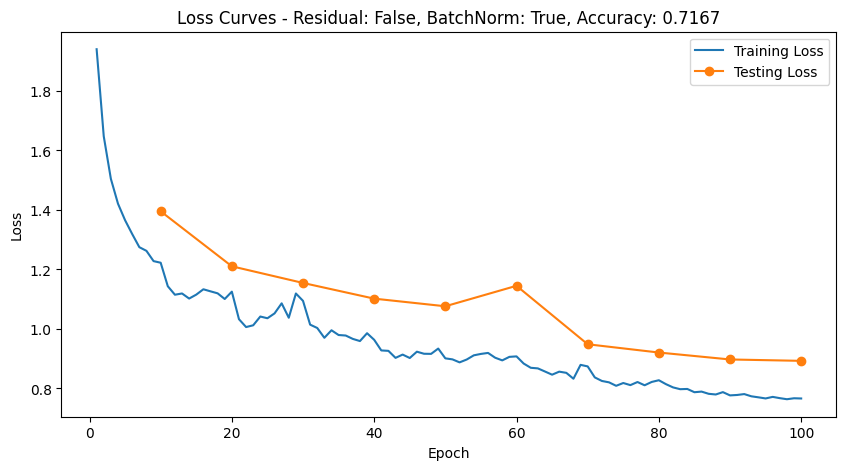


--- Validation ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_residual/0.003/model-80.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 929.74it/s]


Checkpoint 80 Test accuracy: 0.7076
Restored model parameters from models/resnet18_no_residual/0.003/model-90.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 931.46it/s]


Checkpoint 90 Test accuracy: 0.7214
Restored model parameters from models/resnet18_no_residual/0.003/model-100.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 932.28it/s]


Checkpoint 100 Test accuracy: 0.7262

--- Test ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_residual/0.003/model-100.ckpt


100%|██████████| 10000/10000 [00:10<00:00, 931.62it/s]


Checkpoint 100 Test accuracy: 0.7167

--- Training with learning rate 0.003, Residual: True, BatchNorm: True ---
### Training... ###
Epoch 1 Loss 1.727436 Duration 10.291 seconds, LR: 0.003000.
Epoch 2 Loss 1.301219 Duration 10.562 seconds, LR: 0.003000.
Epoch 3 Loss 1.124339 Duration 10.519 seconds, LR: 0.003000.
Epoch 4 Loss 1.025536 Duration 10.079 seconds, LR: 0.003000.
Epoch 5 Loss 0.943475 Duration 10.370 seconds, LR: 0.003000.
Epoch 6 Loss 0.891941 Duration 9.910 seconds, LR: 0.003000.
Epoch 7 Loss 0.851515 Duration 10.227 seconds, LR: 0.003000.
Epoch 8 Loss 0.818560 Duration 10.450 seconds, LR: 0.003000.
Epoch 9 Loss 0.787998 Duration 10.500 seconds, LR: 0.003000.
Epoch 10 Loss 0.769859 Duration 10.403 seconds, LR: 0.003000.
Checkpoint has been created.
Epoch 10/100, Testing Loss: 0.9391
Epoch 11 Loss 0.683301 Duration 10.136 seconds, LR: 0.002000.
Epoch 12 Loss 0.664441 Duration 10.221 seconds, LR: 0.002000.
Epoch 13 Loss 0.648805 Duration 10.070 seconds, LR: 0.002000.
Epoch 1

100%|██████████| 10000/10000 [00:11<00:00, 878.83it/s]


Final Testing Accuracy: 0.8301


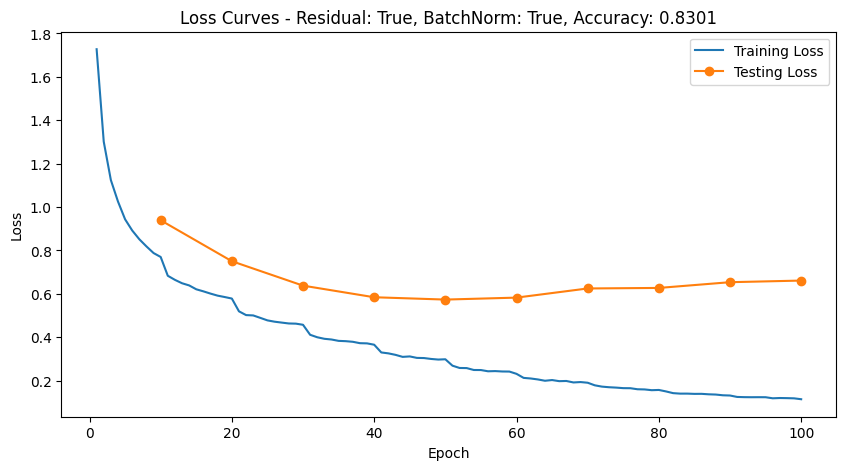


--- Validation ---
### Test or Validation ###
Restored model parameters from models/resnet18/0.003/model-80.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 890.02it/s]


Checkpoint 80 Test accuracy: 0.8374
Restored model parameters from models/resnet18/0.003/model-90.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 891.42it/s]


Checkpoint 90 Test accuracy: 0.8446
Restored model parameters from models/resnet18/0.003/model-100.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 889.47it/s]


Checkpoint 100 Test accuracy: 0.8446

--- Test ---
### Test or Validation ###
Restored model parameters from models/resnet18/0.003/model-100.ckpt


100%|██████████| 10000/10000 [00:11<00:00, 882.16it/s]


Checkpoint 100 Test accuracy: 0.8301

--- Training with learning rate 0.01, Residual: True, BatchNorm: False ---
### Training... ###
Epoch 1 Loss 191.102659 Duration 9.914 seconds, LR: 0.010000.
Epoch 2 Loss 2.409523 Duration 10.041 seconds, LR: 0.010000.
Epoch 3 Loss 4.645370 Duration 10.199 seconds, LR: 0.010000.
Epoch 4 Loss 2.303293 Duration 10.150 seconds, LR: 0.010000.
Epoch 5 Loss 2.303148 Duration 9.768 seconds, LR: 0.010000.
Epoch 6 Loss 2.303293 Duration 9.745 seconds, LR: 0.010000.
Epoch 7 Loss 2.303224 Duration 9.898 seconds, LR: 0.010000.
Epoch 8 Loss 2.303232 Duration 9.866 seconds, LR: 0.010000.
Epoch 9 Loss 2.303359 Duration 9.714 seconds, LR: 0.010000.
Epoch 10 Loss 2.303120 Duration 9.962 seconds, LR: 0.010000.
Checkpoint has been created.
Epoch 10/100, Testing Loss: 2.3326
Epoch 11 Loss 2.303151 Duration 9.976 seconds, LR: 0.006667.
Epoch 12 Loss 2.303078 Duration 10.033 seconds, LR: 0.006667.
Epoch 13 Loss 2.303046 Duration 9.819 seconds, LR: 0.006667.
Epoch 14 Loss

100%|██████████| 10000/10000 [00:08<00:00, 1178.39it/s]



Final Testing Accuracy: 0.7394


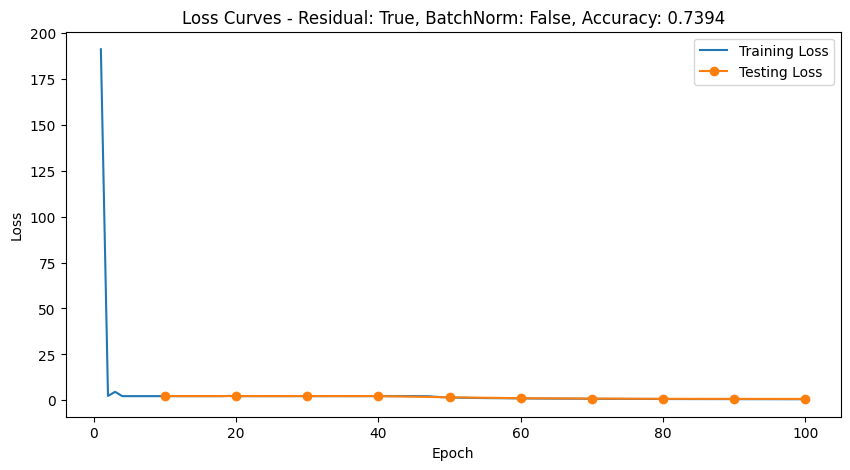


--- Validation ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_bn/0.01/model-80.ckpt


100%|██████████| 5000/5000 [00:04<00:00, 1176.57it/s]


Checkpoint 80 Test accuracy: 0.7352
Restored model parameters from models/resnet18_no_bn/0.01/model-90.ckpt


100%|██████████| 5000/5000 [00:04<00:00, 1191.58it/s]


Checkpoint 90 Test accuracy: 0.7376
Restored model parameters from models/resnet18_no_bn/0.01/model-100.ckpt


100%|██████████| 5000/5000 [00:04<00:00, 1184.44it/s]


Checkpoint 100 Test accuracy: 0.7520

--- Test ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_bn/0.01/model-100.ckpt


100%|██████████| 10000/10000 [00:08<00:00, 1211.74it/s]


Checkpoint 100 Test accuracy: 0.7394

--- Training with learning rate 0.01, Residual: False, BatchNorm: True ---
### Training... ###
Epoch 1 Loss 2.113613 Duration 10.020 seconds, LR: 0.010000.
Epoch 2 Loss 1.811491 Duration 10.077 seconds, LR: 0.010000.
Epoch 3 Loss 1.654836 Duration 10.337 seconds, LR: 0.010000.
Epoch 4 Loss 1.526275 Duration 10.333 seconds, LR: 0.010000.
Epoch 5 Loss 1.454058 Duration 9.914 seconds, LR: 0.010000.
Epoch 6 Loss 1.413196 Duration 10.203 seconds, LR: 0.010000.
Epoch 7 Loss 1.374948 Duration 10.250 seconds, LR: 0.010000.
Epoch 8 Loss 1.362214 Duration 10.459 seconds, LR: 0.010000.
Epoch 9 Loss 1.339125 Duration 10.237 seconds, LR: 0.010000.
Epoch 10 Loss 1.352879 Duration 10.393 seconds, LR: 0.010000.
Checkpoint has been created.
Epoch 10/100, Testing Loss: 1.7160
Epoch 11 Loss 1.277124 Duration 10.475 seconds, LR: 0.006667.
Epoch 12 Loss 1.313515 Duration 10.096 seconds, LR: 0.006667.
Epoch 13 Loss 1.319741 Duration 10.082 seconds, LR: 0.006667.
Epoch 1

100%|██████████| 10000/10000 [00:10<00:00, 927.27it/s]


Final Testing Accuracy: 0.5720


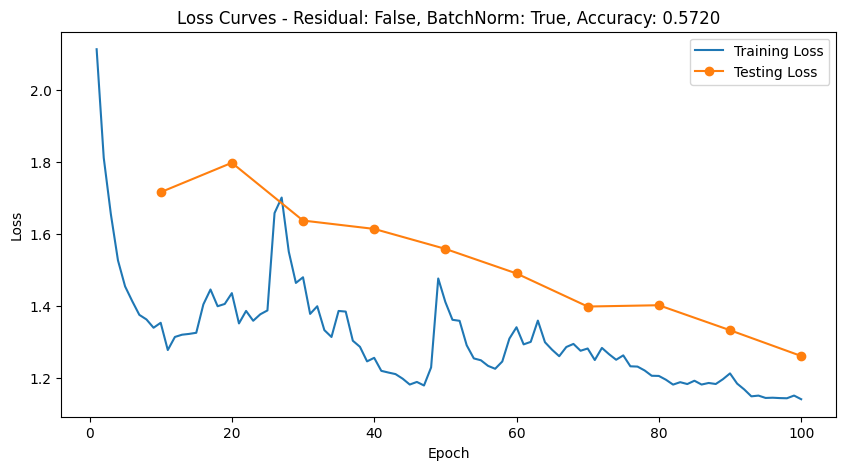


--- Validation ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_residual/0.01/model-80.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 914.25it/s]


Checkpoint 80 Test accuracy: 0.5446
Restored model parameters from models/resnet18_no_residual/0.01/model-90.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 921.81it/s]


Checkpoint 90 Test accuracy: 0.5530
Restored model parameters from models/resnet18_no_residual/0.01/model-100.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 919.24it/s]


Checkpoint 100 Test accuracy: 0.5804

--- Test ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_residual/0.01/model-100.ckpt


100%|██████████| 10000/10000 [00:10<00:00, 915.87it/s]


Checkpoint 100 Test accuracy: 0.5720

--- Training with learning rate 0.01, Residual: True, BatchNorm: True ---
### Training... ###
Epoch 1 Loss 1.992111 Duration 10.771 seconds, LR: 0.010000.
Epoch 2 Loss 1.469793 Duration 10.286 seconds, LR: 0.010000.
Epoch 3 Loss 1.268450 Duration 10.293 seconds, LR: 0.010000.
Epoch 4 Loss 1.168841 Duration 9.990 seconds, LR: 0.010000.
Epoch 5 Loss 1.112771 Duration 10.089 seconds, LR: 0.010000.
Epoch 6 Loss 1.081251 Duration 10.527 seconds, LR: 0.010000.
Epoch 7 Loss 1.041205 Duration 10.570 seconds, LR: 0.010000.
Epoch 8 Loss 1.020568 Duration 10.510 seconds, LR: 0.010000.
Epoch 9 Loss 1.012818 Duration 10.333 seconds, LR: 0.010000.
Epoch 10 Loss 0.989777 Duration 10.610 seconds, LR: 0.010000.
Checkpoint has been created.
Epoch 10/100, Testing Loss: 1.1412
Epoch 11 Loss 0.903699 Duration 10.312 seconds, LR: 0.006667.
Epoch 12 Loss 0.886486 Duration 10.526 seconds, LR: 0.006667.
Epoch 13 Loss 0.879726 Duration 10.366 seconds, LR: 0.006667.
Epoch 14

100%|██████████| 10000/10000 [00:11<00:00, 888.19it/s]



Final Testing Accuracy: 0.8074


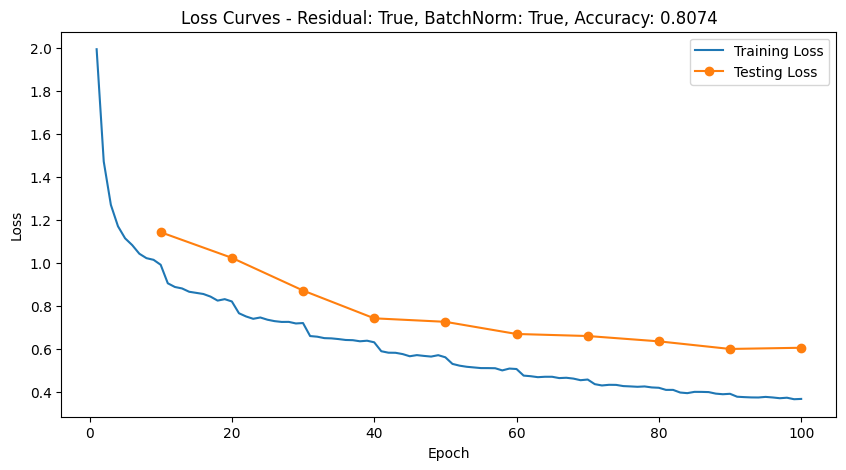


--- Validation ---
### Test or Validation ###
Restored model parameters from models/resnet18/0.01/model-80.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 877.62it/s]


Checkpoint 80 Test accuracy: 0.8028
Restored model parameters from models/resnet18/0.01/model-90.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 883.69it/s]


Checkpoint 90 Test accuracy: 0.8138
Restored model parameters from models/resnet18/0.01/model-100.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 885.95it/s]


Checkpoint 100 Test accuracy: 0.8150

--- Test ---
### Test or Validation ###
Restored model parameters from models/resnet18/0.01/model-100.ckpt


100%|██████████| 10000/10000 [00:11<00:00, 880.96it/s]


Checkpoint 100 Test accuracy: 0.8074

--- Training with learning rate 0.03, Residual: True, BatchNorm: False ---
### Training... ###
Epoch 1 Loss 5892843256.839340 Duration 9.874 seconds, LR: 0.030000.
Epoch 2 Loss 439642343012.019043 Duration 10.156 seconds, LR: 0.030000.
Epoch 3 Loss 2.303523 Duration 9.706 seconds, LR: 0.030000.
Epoch 4 Loss 2.303844 Duration 9.890 seconds, LR: 0.030000.
Epoch 5 Loss 2.303949 Duration 10.089 seconds, LR: 0.030000.
Epoch 6 Loss 364166485545.652466 Duration 9.868 seconds, LR: 0.030000.
Epoch 7 Loss 16270794755176.365234 Duration 10.200 seconds, LR: 0.030000.
Epoch 8 Loss 2.304298 Duration 10.331 seconds, LR: 0.030000.
Epoch 9 Loss 2.303874 Duration 10.409 seconds, LR: 0.030000.
Epoch 10 Loss 769137033.226880 Duration 10.436 seconds, LR: 0.030000.
Checkpoint has been created.
Epoch 10/100, Testing Loss: 2.3345
Epoch 11 Loss 2.303742 Duration 10.345 seconds, LR: 0.020000.
Epoch 12 Loss 2.303943 Duration 9.958 seconds, LR: 0.020000.
Epoch 13 Loss 2.30403

100%|██████████| 10000/10000 [00:08<00:00, 1211.62it/s]



Final Testing Accuracy: 0.1000


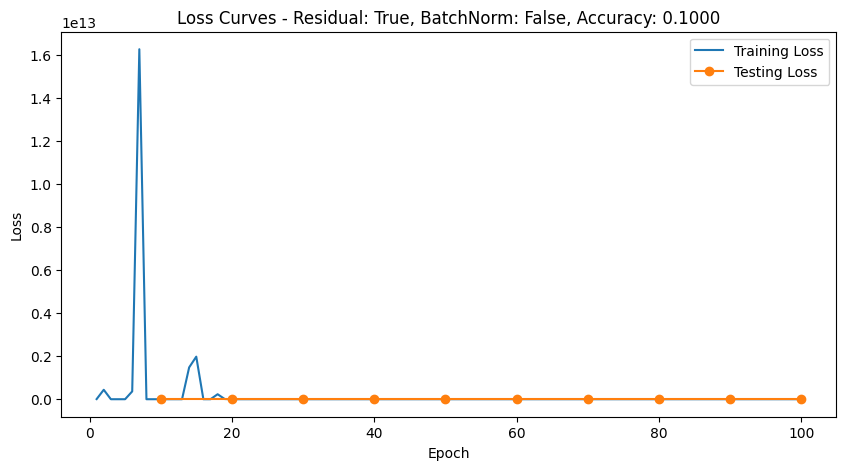


--- Validation ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_bn/0.03/model-80.ckpt


100%|██████████| 5000/5000 [00:04<00:00, 1183.00it/s]


Checkpoint 80 Test accuracy: 0.0958
Restored model parameters from models/resnet18_no_bn/0.03/model-90.ckpt


100%|██████████| 5000/5000 [00:04<00:00, 1207.27it/s]


Checkpoint 90 Test accuracy: 0.0950
Restored model parameters from models/resnet18_no_bn/0.03/model-100.ckpt


100%|██████████| 5000/5000 [00:04<00:00, 1207.54it/s]


Checkpoint 100 Test accuracy: 0.0950

--- Test ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_bn/0.03/model-100.ckpt


100%|██████████| 10000/10000 [00:08<00:00, 1210.23it/s]


Checkpoint 100 Test accuracy: 0.1000

--- Training with learning rate 0.03, Residual: False, BatchNorm: True ---
### Training... ###
Epoch 1 Loss 2.221269 Duration 10.533 seconds, LR: 0.030000.
Epoch 2 Loss 1.929664 Duration 9.799 seconds, LR: 0.030000.
Epoch 3 Loss 1.897510 Duration 10.157 seconds, LR: 0.030000.
Epoch 4 Loss 1.889693 Duration 10.366 seconds, LR: 0.030000.
Epoch 5 Loss 1.888572 Duration 10.057 seconds, LR: 0.030000.
Epoch 6 Loss 1.916941 Duration 10.062 seconds, LR: 0.030000.
Epoch 7 Loss 1.946518 Duration 9.881 seconds, LR: 0.030000.
Epoch 8 Loss 1.928015 Duration 9.970 seconds, LR: 0.030000.
Epoch 9 Loss 1.912056 Duration 10.162 seconds, LR: 0.030000.
Epoch 10 Loss 1.893797 Duration 9.950 seconds, LR: 0.030000.
Checkpoint has been created.
Epoch 10/100, Testing Loss: 2.7321
Epoch 11 Loss 1.872415 Duration 9.919 seconds, LR: 0.020000.
Epoch 12 Loss 1.879697 Duration 9.930 seconds, LR: 0.020000.
Epoch 13 Loss 1.874396 Duration 10.085 seconds, LR: 0.020000.
Epoch 14 Los

100%|██████████| 10000/10000 [00:10<00:00, 925.03it/s]



Final Testing Accuracy: 0.3183


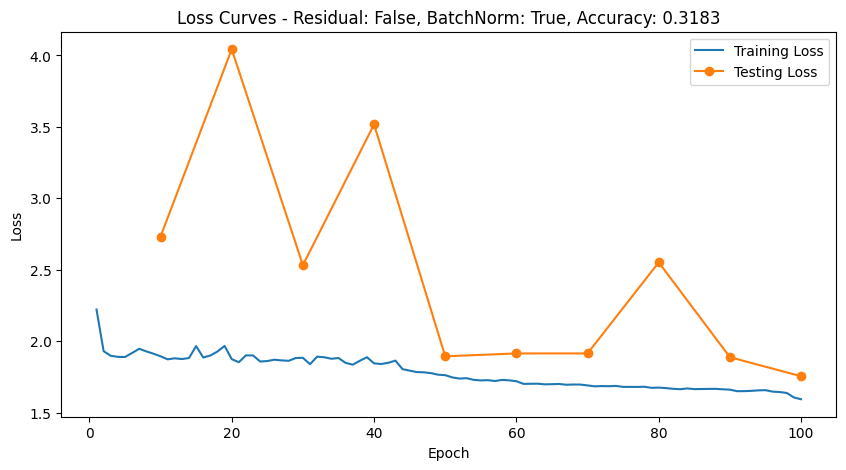


--- Validation ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_residual/0.03/model-80.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 935.04it/s]


Checkpoint 80 Test accuracy: 0.0948
Restored model parameters from models/resnet18_no_residual/0.03/model-90.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 921.41it/s]


Checkpoint 90 Test accuracy: 0.3052
Restored model parameters from models/resnet18_no_residual/0.03/model-100.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 943.00it/s]


Checkpoint 100 Test accuracy: 0.3164

--- Test ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_residual/0.03/model-100.ckpt


100%|██████████| 10000/10000 [00:10<00:00, 933.88it/s]


Checkpoint 100 Test accuracy: 0.3183

--- Training with learning rate 0.03, Residual: True, BatchNorm: True ---
### Training... ###
Epoch 1 Loss 2.308196 Duration 10.292 seconds, LR: 0.030000.
Epoch 2 Loss 1.809272 Duration 10.705 seconds, LR: 0.030000.
Epoch 3 Loss 1.642130 Duration 10.332 seconds, LR: 0.030000.
Epoch 4 Loss 1.490668 Duration 10.230 seconds, LR: 0.030000.
Epoch 5 Loss 1.431093 Duration 10.360 seconds, LR: 0.030000.
Epoch 6 Loss 1.402474 Duration 10.242 seconds, LR: 0.030000.
Epoch 7 Loss 1.393674 Duration 10.555 seconds, LR: 0.030000.
Epoch 8 Loss 1.381401 Duration 10.362 seconds, LR: 0.030000.
Epoch 9 Loss 1.368315 Duration 10.576 seconds, LR: 0.030000.
Epoch 10 Loss 1.354208 Duration 10.050 seconds, LR: 0.030000.
Checkpoint has been created.
Epoch 10/100, Testing Loss: 2.4830
Epoch 11 Loss 1.286021 Duration 10.433 seconds, LR: 0.020000.
Epoch 12 Loss 1.265587 Duration 10.290 seconds, LR: 0.020000.
Epoch 13 Loss 1.250250 Duration 10.300 seconds, LR: 0.020000.
Epoch 1

100%|██████████| 10000/10000 [00:11<00:00, 878.57it/s]



Final Testing Accuracy: 0.7085


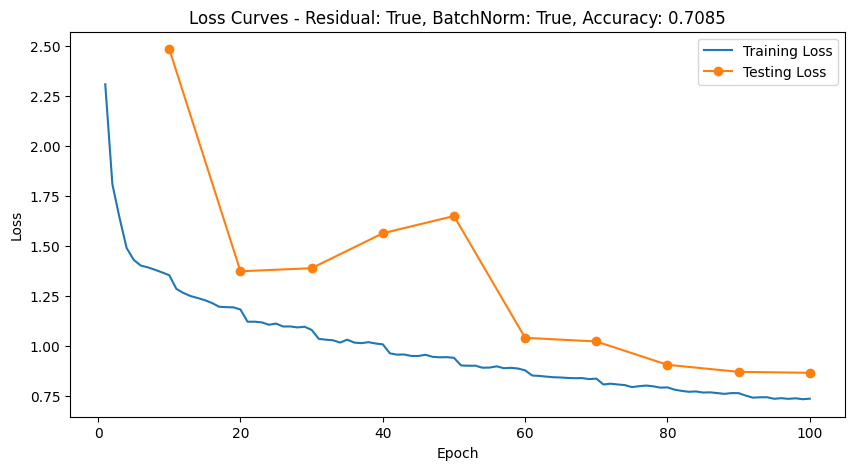


--- Validation ---
### Test or Validation ###
Restored model parameters from models/resnet18/0.03/model-80.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 893.92it/s]


Checkpoint 80 Test accuracy: 0.7096
Restored model parameters from models/resnet18/0.03/model-90.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 881.55it/s]


Checkpoint 90 Test accuracy: 0.7168
Restored model parameters from models/resnet18/0.03/model-100.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 878.15it/s]


Checkpoint 100 Test accuracy: 0.7224

--- Test ---
### Test or Validation ###
Restored model parameters from models/resnet18/0.03/model-100.ckpt


100%|██████████| 10000/10000 [00:11<00:00, 887.70it/s]

Checkpoint 100 Test accuracy: 0.7085


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directory for saving models
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Define configurations for ResNet variations
configs = [
    {"use_residual": True, "use_bn": False, "modeldir": os.path.join(MODEL_DIR, "resnet18_no_bn")},
    {"use_residual": False, "use_bn": True, "modeldir": os.path.join(MODEL_DIR, "resnet18_no_residual")},
    {"use_residual": True, "use_bn": True, "modeldir": os.path.join(MODEL_DIR, "resnet18")},
]

# Define learning rates to test
learning_rates = [0.003, 0.01, 0.03]

# Run experiments for each configuration and learning rate
for lr in learning_rates:
    for config in configs:
        lr_modeldir = os.path.join(config["modeldir"], str(lr))
        os.makedirs(lr_modeldir, exist_ok=True)
        run_experiment(
            batch_size=128,
            save_interval=10,
            weight_decay=2e-4,
            learning_rate=lr,
            modeldir=lr_modeldir,
            use_residual=config["use_residual"],
            use_bn=config["use_bn"],
            device=device,
            save_checkpoint_model = True
        )

In [3]:
configs = [
    {"use_residual": True, "use_bn": False},
    {"use_residual": False, "use_bn": True},
    {"use_residual": True, "use_bn": True},
]

# Run experiments for each configuration with best learning rate
for config in configs:
    run_experiment(
        batch_size=128,
        save_interval=10,
        weight_decay=2e-4,
        learning_rate=0.003,
        modeldir=config["modeldir"],
        use_residual=config["use_residual"],
        use_bn=config["use_bn"],
        device=device,
        save_checkpoint_model = False
    )

KeyError: 'modeldir'